# Big Data -> Big Money?
~LSTM implementation

The aim of this project is to explain the trends in stock prices for different stocks and predict the closing prices using historical data for different stocks and using these predictions to recommend stocks. Here we build a LSTM model using Keras to predict the closing price of stocks as an alternative approach to regression explored earlier.

In [1]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml import regression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as fn
from datetime import datetime, timedelta
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Using TensorFlow backend.


In [2]:
#Reading our cleaned and subsetted data in Spark as follows
stock_df = spark.read.csv('snp500datafinal.csv', header=True, inferSchema=True)
#Reading data for the S&P 500 list
snp=pd.read_csv('constituents_csv.csv')
snpticks=snp['Symbol'].values.tolist()

First we build our model for a single stock and then build a function to work with any stock. Since we use a complex neural network like LSTM as our model to balance the complexity we only use historical data of closing price as our explanatory variable to predict future trends in closing price.

In [3]:
df = stock_df.where(fn.col('ticker')=='AMZN')
#Selecting closing price and date
df = df.select('close','date')

In [4]:
#We create a new column called 'id' to split our data while maintaining the temporal aspect of our data
df = df.withColumn("id",fn.monotonically_increasing_id())

#Let's look at our data
df.show(10)

+-------+----------+---+
|  close|      date| id|
+-------+----------+---+
| 257.31|02-01-2013|  0|
| 258.48|03-01-2013|  1|
| 259.15|04-01-2013|  2|
|268.459|07-01-2013|  3|
| 266.38|08-01-2013|  4|
| 266.35|09-01-2013|  5|
| 265.34|10-01-2013|  6|
| 267.94|11-01-2013|  7|
| 272.73|14-01-2013|  8|
|  271.9|15-01-2013|  9|
+-------+----------+---+
only showing top 10 rows



Train-test split: We now create a Train-test split for cross-validation purposes. However, rather than shuffling the data randomly for the split, since we are dealing with time series data we make this split mainting the temporal aspect of the data and slicing using time as follows.

In [5]:
#We use a 80-20 training-testing split
length = df.count()
itrain = int(0.8*length)
#Train and test values
train = df.where(fn.col('id')<itrain)
valid = df.where(fn.col('id')>=itrain)
#List of train and test values
train = train.select('close').collect()
train = [float(row.close) for row in train]
valid = valid.select('close').collect()
valid = [float(row.close) for row in valid]

For further preperation we scale our data using the MinMax Scaler for faster convergence. 

In [6]:
#Here we scale the entire data using MinMax Scaler 
scaler = MinMaxScaler(feature_range=(0, 1))
data = train.copy()
data.extend(valid)
data=np.reshape(data,(-1,1))
scaled_data = scaler.fit_transform(data)

Next, we construct the features and target label for our model. Here we use 60 values from the training values as the features
and the very next value as our target label. Basically, we will train our model to predict today's closing price using data from past 60 days.

In [7]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
#vectorize training samples
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Now we build and train our LSTM model using keras with two LSTM layers followed by a final dense layer. We also use dropout for regularization to prevent overfitting.

In [8]:
#LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(1))
#Compile it and fit it on our training data
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5, batch_size=5, verbose=2)

Epoch 1/5
 - 8s - loss: 0.0012
Epoch 2/5
 - 8s - loss: 2.7775e-04
Epoch 3/5
 - 8s - loss: 2.1417e-04
Epoch 4/5
 - 9s - loss: 1.8520e-04
Epoch 5/5
 - 8s - loss: 1.6955e-04


In [9]:
#For generalization performance measure, we predict the validation set using past 60 values from the training data
inputs = data[len(data) - len(valid) - 60:]
inputs = np.array(inputs)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

We use RMSE to check performance on validation set

In [10]:
rms=np.sqrt(np.mean(np.power((valid-pred),2)))
rms

361.4640261945741

Finally let's see the predictions from the model against the actual values.

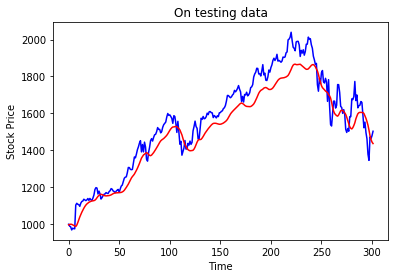

In [11]:
plt.plot(valid,'-b',label='Test')
plt.plot(pred,'-r',label='Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('On testing data')
plt.show()

Next we create functions to perform the above tasks on different tickers

In [12]:
#This function create a LSTM model for a given stock ticker 
def tt_split(df):
    df = df.withColumn("id",fn.monotonically_increasing_id())
    i = df.select('id').collect()[0][0]
    length = df.count()
    itrain = int(0.8*length)
    train = df.where(fn.col('id')<i+itrain)
    valid = df.where(fn.col('id')>=i+itrain)
    train = train.select('close').collect()
    train = [float(row.close) for row in train]
    valid = valid.select('close').collect()
    valid = [float(row.close) for row in valid]
    #converting dataset into x_train and y_train
    data = train.copy()
    data.extend(valid)
    data=np.reshape(data,(-1,1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    #Validation set
    inputs = np.array(data[len(data) - len(valid) - 60:])
    inputs  = scaler.transform(inputs)
    x_test = []
    for i in range(60,inputs.shape[0]):
        x_test.append(inputs[i-60:i,0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    y_test = valid
    return x_train, y_train, x_test, y_test, scaler

def train_model(x_train, y_train, epochs, batch_size):
    #creating lstm model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

def predict(x_test, y_test, model, model_name, scaler):
    pred = model.predict(x_test)
    pred = scaler.inverse_transform(pred)
    rms=np.sqrt(np.mean(np.power((y_test-pred),2)))
    results.append({"ticker":model_name,"rmse":rms})


def save_model(model, model_name):
    filename= model_name+".h5"
    model.save('models/'+filename)

In [13]:
#We test our functions on different stocks
results = []
for val,x in enumerate(['AMZN','AAPL','EXPE','CVS','BAC','GOOGL']): 
    df = stock_df.where(fn.col('ticker')==x)
    df = df.select('close','date')
    x_train, y_train, x_test, y_test, s = tt_split(df)
    print(val+1,x,' model training...')
    model = train_model(x_train,y_train,epochs=5,batch_size=5)
    save_model(model,x)
    predict(x_test, y_test, model, x, s)

1 AMZN  model training...
2 AAPL  model training...
3 EXPE  model training...
4 CVS  model training...
5 BAC  model training...
6 GOOGL  model training...


In [14]:
results

[{'ticker': 'AMZN', 'rmse': 362.71349950833155},
 {'ticker': 'AAPL', 'rmse': 27.38590835585094},
 {'ticker': 'EXPE', 'rmse': 12.886522513850464},
 {'ticker': 'CVS', 'rmse': 7.330504426607596},
 {'ticker': 'BAC', 'rmse': 2.6999737465768083},
 {'ticker': 'GOOGL', 'rmse': 104.82556756371828}]

Recommend Stocks: This function defined below takes in input as month, day and year for which you want the stocks to be predicted and a list of stocks from which you want a recommendation. Inside this function, the models are picked up from the folder and historical stock data is used. The models predict stock price on that particular date using last 60 day's stock price values. Finally, it calculates the return values and ranks the stocks based on the return for this day.

In [15]:
def recommend(month,day,year,stocks,stock_df):
  results=[]
  filenames=[x+".h5" for x in stocks] 
  for stockmodel in filenames:
    df = stock_df.where(fn.col('ticker')==stockmodel[:-3])
    df = df.select('close','date','open')
    df = df.withColumn("id",fn.monotonically_increasing_id()) #to get row number
    
    #fitting our scaler on the entire closing price data
    data=df.select('close').collect()
    data=np.reshape(data,(-1,1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(data)
    
    #getting data of previous 60 values for given date
    dt=day+"-"+month+"-"+year
    idx=df.where(fn.col('date')==dt).select('id').collect()[0][0] #row number for given date
    test=df.where((fn.col('id')<idx) & (fn.col('id')>=idx-60)) #past 60 days
    inputs=test.select('close').collect()

    #transform for prediction
    inputs = np.reshape(inputs,(-1,1))
    inputs  = scaler.transform(inputs)
    x_test = np.array([inputs])
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

    #predicting that day's stock price and calculating return
    model=load_model("models/"+stockmodel) #Loading the model
    closing_price = model.predict(x_test)
    closing_price = scaler.inverse_transform(closing_price)[0][0] #given date's prediction
    opening_price = df.where(fn.col('date')==dt).select('open').collect()[0][0] #given date's opening price
    return_value=(closing_price-opening_price)/opening_price
    
    #collecting all the return values
    results.append({"ticker":stockmodel[:-3],"return":return_value})
  
  #ranking stocks based on return values
  results=sorted(results, key = lambda i: i['return'],reverse=True)
  return results

In [16]:
#Let's look at our results
recommend('10','04','2017',['AMZN','AAPL', 'EXPE', 'CVS', 'BAC', 'GOOGL'],stock_df)

[{'ticker': 'GOOGL', 'return': 0.015333667295680012},
 {'ticker': 'AMZN', 'return': -0.008510460592073586},
 {'ticker': 'CVS', 'return': -0.012508510217089068},
 {'ticker': 'BAC', 'return': -0.014818880416032219},
 {'ticker': 'AAPL', 'return': -0.017391789590350978},
 {'ticker': 'EXPE', 'return': -0.02074600760228635}]

Thus, we see for this particular day Google is the recommended stock based on the return value from our list of stocks. 
We can extend this approach to recommend stocks based their future trends rather than a single day's return. However, this helps us get an intuition for a single day.